# Trans-Inpainter: Wireless Channel Information-Guided Image Restoration via Multimodal Transformer

# General Info

**Course**: Neural Networks

**Academic Year**: 2023/2024

**Authors**: Pontiggia Alessia 1892079, Paladino Gerardo 1918178


# Introduction

This notebook aims to clarify and describe the methods used to reimplement the paper ["Trans-Inpainter: Wireless Channel Information-Guided Image Restoration via Multimodal Transformer"](https://arxiv.org/abs/2305.05385).


# Technology

The project has been run with **GPU P100** free version available on Kaggle.

# Dataset

Thanks to Prof. Grassucci we asked the paper's authors to publish the dataset they used, taken in a proper laboratory set up. Unfortunately, this dataset is not yet available online, thus we had to move to another approach, since the reproduction of the CSI signals couldn't be done in a reasonable way.

Hence, the dataset used is a subset of [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html).

Due to high memory usage ("*Your session crashed after using all available RAM*" was the error we got while training the model), we aimed to reconstruct images of a particular label only (class 5, dogs).
This partition, consisting of 5000 samples, is then divided into:
- training set: 4500 samples
- validation set: 500 samples
- test set: 1000 samples

The **"original" images** of the dataset are used as groundthruth for the model. The original images have shape 3x32x32 and the form:

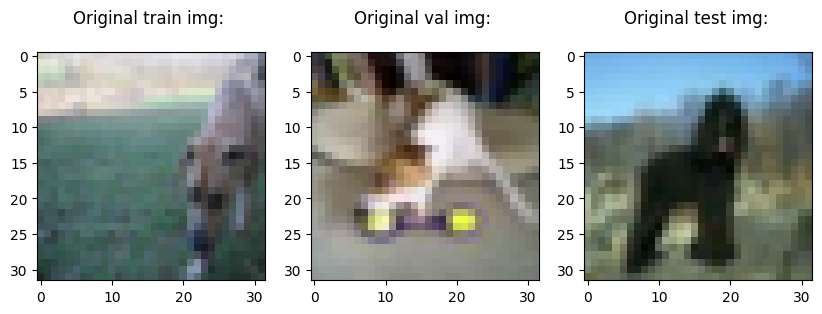

The **"defective" images** which have to be reconstructed are obtained by applying a mask of size 10 on the original ones. The defective images are taken as input for the model.
The defective images have shape 3x32x32 and the form:


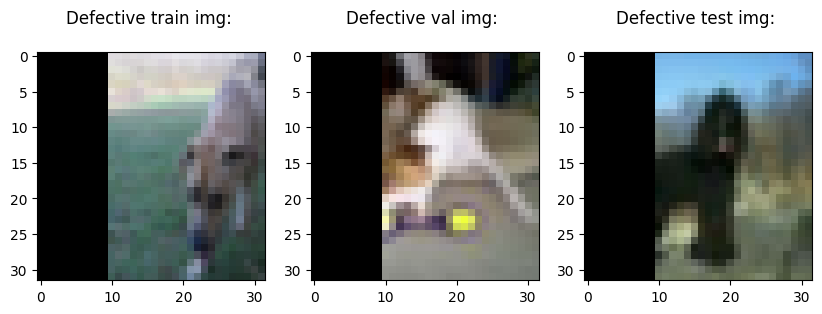

The "*simulation*" of the CSI is thought as the occluded part that should have been captured by the cameras and processed as wifi signal. In our case it is simply the excluded part by the mask.
The **"*simulated*" csi images** are used as input of the model, together with the defective ones.
The "*simulated*" csi images have shape 3x32x10 and the form:

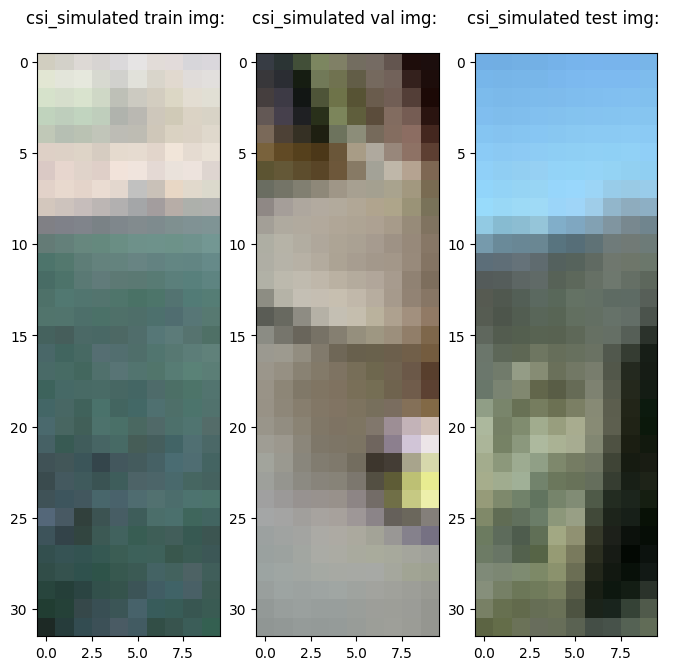




# Architecture

The replicated architecture is the following:

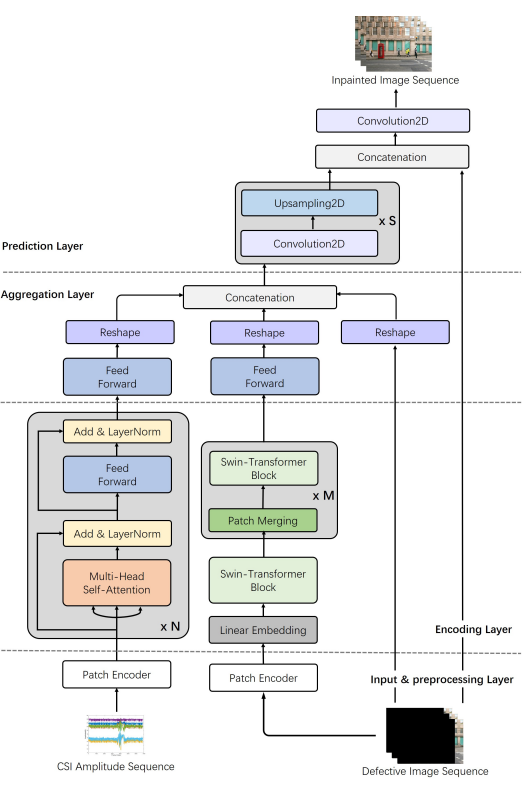

We tried being as faithful as possible to this implementation.

The only things we changed are:
- num_heads = 2 (not 3)
- embed_dim = 256 (not 1000)
- M = 1 (not 3)

As the above figure shows, the architecture of the **TransInpainterModel** has six main components:

- The **Patch_Encoder_CSI**:

            Input Tensor (16x3x32x10)
                   │
                   ▼
         Linear Layer (in_features=10, out_features=256)
         ┌─────────────────────────────────────────┐
         │ Weight Matrix (10x256)                  │
         │ Bias Vector (256)                       │
         └─────────────────────────────────────────┘
                   │
                   ▼
            Output Tensor (16x3x32x256)
    

- The **EncodingLayer_CSI**:

            Input Tensor (16x3x32x256)
                   │
                   ▼
          Layer Normalization (16x3x32x256)
                   │
                   ▼

          Normalized Tensor (16x3x32x256)
                   |
                   ▼
          Multi-Head Attention   
                  |-- Reshape & Permute: (16x3x32x256) -> (32x48x256)
                  |-- Attention Operation
                  |-- Reshape: (32x48x256) -> (16x3x32x256)
                  |
                  ▼
          Attention Output (16x3x32x256)
                  |
                  ▼
          Add & Normalize (1st)
                  |-- Addition: (Normalized Tensor + Attention Output)
                  |-- Normalization
                  |
                  ▼
          Output (16x3x32x256)
                  |
                  ▼
          Feed Forward Layer
                  |-- Linear1: (in_features=256, hidden_units[0]=512)
                  |-- GELU Activation
                  |-- Dropout
                  |-- Linear2: (hidden_units[0]=512, hidden_units[1]=16x3x32x256)
                  |-- GELU Activation
                  |-- Dropout
                  |-- Reshape: (flattened -> 16x3x32x256)
                  |
                  ▼
          Feed Forward Output (16x3x32x256)
                  |
                  ▼
          Add & Normalize (2nd)
                  |-- Addition: (Output + Feed Forward Output)
                  |-- Normalization
                  |
                  ▼
          Final Output (16x3x32x256)


- The **Patch_Encoder_Mask**:

            Input Tensor (16x3x32x32)
                   │
                   ▼
         Linear Layer (in_features=32, out_features=256)
         ┌─────────────────────────────────────────┐
         │ Weight Matrix (32x256)                  │
         │ Bias Vector (256)                       │
         └─────────────────────────────────────────┘
                   │
                   ▼
            Output Tensor (16x3x32x256)

- The **EncoderLayer_Mask**:

              Input Tensor (16x3x32x256)
                          │
                          ▼
      +--------------------------------------------+
      |            SwinTransformerBlock            |
      |                                            |
      |           Input: (16x3x32x256)             |
      |                   │                        |
      |                   ▼                        |
      | ┌────────────────────────────────────────┐ |
      | │   Swin Transformer Model (Pretrained)  │ |
      | │       + Bilinear Interpolation         │ |
      | │       + Swin Transformer Processing    │ |
      | └────────────────────────────────────────┘ |
      |                    │                       |
      |                    ▼                       |
      |         Output: (16, 3, 224, 224)          |     
      |                                            |
      |           DenseLayer                       |
      |                                            |
      |         Input: (16, 3, 224, 224)           |
      |                     │                      |
      |                     ▼                      |
      | ┌───────────────────────────────────────┐  |
      | │   Linear Layer                        │  |
      | │   (1000 -> 784)                       │  |
      | │   Weight Matrix (1000x784)            │  |
      | │   Bias Vector (784)                   │  |
      | └───────────────────────────────────────┘  |
      |                     │                      |
      |                     ▼                      |
      |          Output: (16, 784)                 |
      +--------------------------------------------+

- The **Aggregation Layer**:

        Input Tensors
        (encoded_csi: 16x3x32x256,
        encoded_mask: 16x784,
        mask: 16x3x32x32)
            │
            ▼
        +-------------------+
        |  AggregationLayer |
        |                   |
        |  +-------------+  |
        |  |  Flatten    |  |
        |  |  Layer      |  |
        |  +-------------+  |
        |        │          |
        |        ▼          |
        |  +-------------+  |
        |  |  Dropout    |  |
        |  |             |  |
        |  +-------------+  |
        |        │          |
        |        ▼          |
        |  +-------------+  |
        |  | FeedForward |  |
        |  |  Layer2     |  |
        |  +-------------+  |
        |        │          |
        |        ▼          |
        |  +-------------+  |
        |  |  Reshape    |  |
        |  |  Layer      |  |
        |  +-------------+  |
        |        │          |
        |        ▼          |
        |  +-------------+  |
        |  |  Resize     |  |
        |  |  Layer      |  |
        |  +-------------+  |
        |        │          |
        |        ▼          |
        |  +-------------+  |
        |  | Concatenate |  |
        |  |  Layer      |  |
        |  +-------------+  |
        |        │          |
        |        ▼          |
        |  Output Tensor   |
        |  (16x5x28x28)    |
        +-------------------+


- The **Decoder Layer**:

        Input Tensor
        (16, 5, 28, 28)
            │
            ▼
        +----------------+
        |  DecoderLayer  |
        |                |
        |  +----------+  |
        |  |  Conv1   |  |
        |  |          |  |
        |  |  5 -> 10 |  |
        |  +----------+  |
        |       │        |
        |       ▼        |
        |  +----------+  |
        |  |  Conv2   |  |
        |  |          |  |
        |  |  10 -> 5 |  |
        |  +----------+  |
        |       │        |
        |       ▼        |
        |  +----------+  |
        |  |  Conv3   |  |
        |  |          |  |
        |  |  5 -> 3  |  |
        |  +----------+  |
        |       │        |
        |       ▼        |
        |  +----------+  |
        |  | Upsample |  |
        |  |          |  |
        |  |  (32x32) |  |
        |  +----------+  |
        |       │        |
        |       ▼        |
        | Output Tensor  |
        | (16, 3, 32, 32)|
        +----------------+



# Training and Validation

The training phase consists of:

- **number of epochs**: 100
- **learning rate**: 0.001
- **loss**: Mean Squared Error
- **optimizer**: Adam
- **scheduler**: Exponential LR with γ=0.9
- **batch_size**: 16
- **regularization technique**: Early Stopping set with patience = 5 on the validation loss


Here some plots of the groundthruth and inpainted images at different (increasing by 5) epochs.


- **Epoch: 0**:

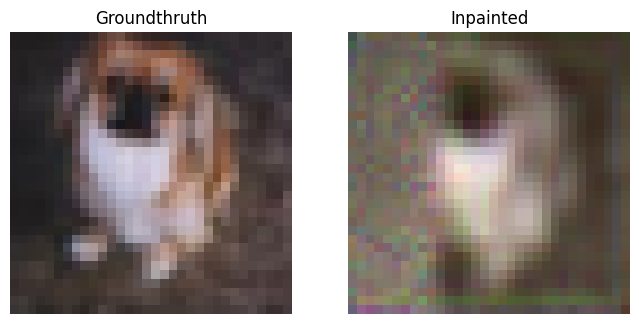

- **Epoch: 5**

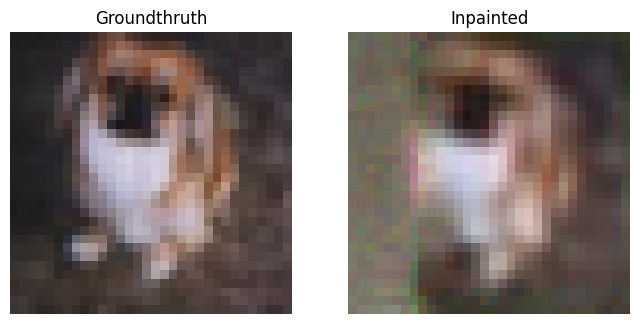

- **Epoch: 10**

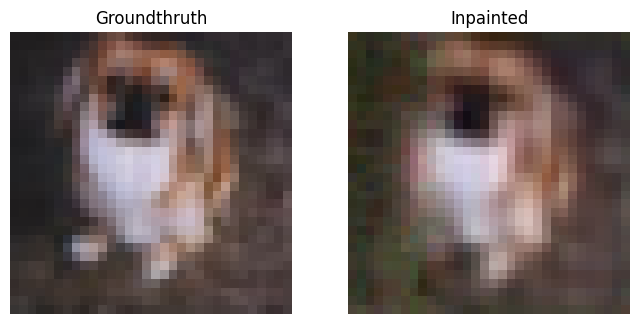

- **Epoch: 15**:

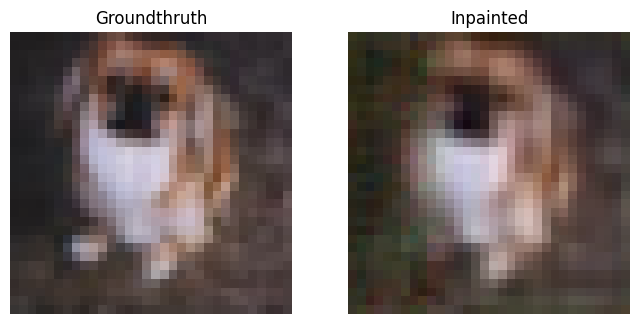

- **Epoch: 20**:

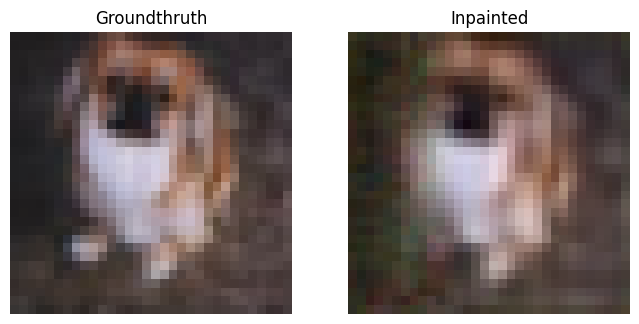

# Test and Results

The metrics used to evaluate the performances on the test set are:

- **Average loss**: 0.011529496780806971
- **Average ssim**: 0.8438719900012611
- **Average PSNR**: 19.407058167993924

You can also find some test inpainted images below:

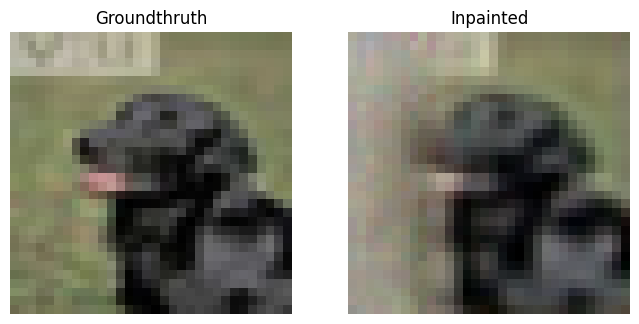

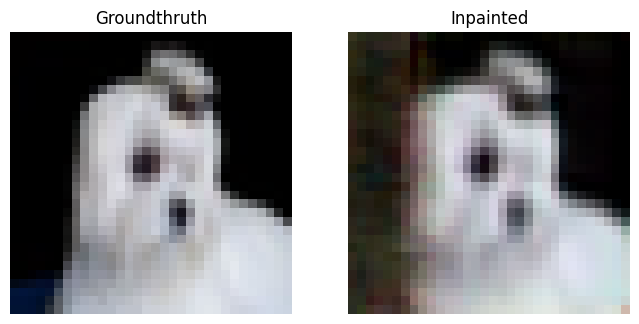

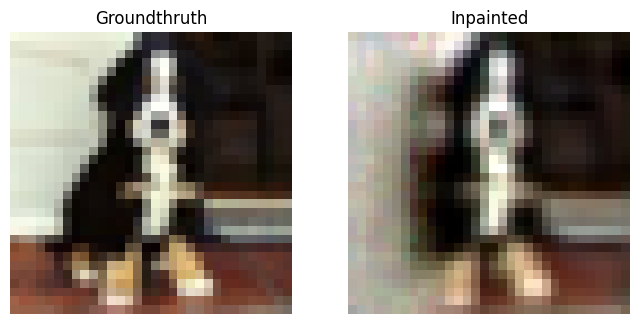